In [16]:
import pathlib
import requests

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import compose, datasets, dummy, ensemble, impute, metrics
from sklearn import model_selection, pipeline, preprocessing, tree

# Boosting methods


## 1. Framing the Problem

In this tutorial you will learn how to apply boosting methods to predict the sales price of a house. House price prediction is a supervised learning, regression problem. The performance measure that you will use is Mean Absolute Percentage error (MAPE).

In [ ]:
metrics.mean_absolute_percentage_error?

In [2]:
SCORING = "neg_mean_absolute_percentage_error"

## 2. Get the data

In [3]:
train_df = pd.read_csv("sample_data/california_housing_train.csv")
test_df = pd.read_csv("sample_data/california_housing_test.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [5]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
train_features_df = train_df.drop("median_house_value", axis=1)
train_target = train_df.loc[:, "median_house_value"]

In [7]:
train_features_df .head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250


In [8]:
train_target.head()

,median_house_value
0,66900.0
1,80100.0
2,85700.0
3,73400.0
4,65500.0


## 3. Exploratory Data Analysis

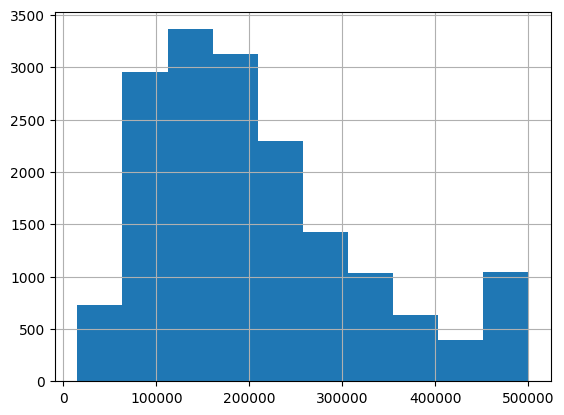

In [9]:
_ = train_target.hist()

## 4. Prepare Data for ML

In [10]:
preprocessing_pipeline = pipeline.make_pipeline(
    impute.SimpleImputer(),
    preprocessing.StandardScaler(),
    verbose=True,
).set_output(transform="pandas")


## 5. Short-list Promising Models

### Benchmark Model

In [18]:
_regressor = dummy.DummyRegressor(
    strategy="median"
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

benchmark_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

benchmark_cv_scores = model_selection.cross_val_score(
    benchmark_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

print(np.mean(-benchmark_cv_scores * 100))

54.12482850502285


### Adaboost

In [11]:
ensemble.AdaBoostRegressor?

In [12]:
_estimator = tree.DecisionTreeRegressor()

_regressor = ensemble.AdaBoostRegressor(
    estimator=_estimator
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

adaboost_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor ,
    verbose=True,
)

In [13]:
adaboost_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())],
                          verbose=True)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=AdaBoostRegressor(estimator=DecisionTreeRegressor())))],
         verbose=True)

In [14]:
cv_scores = model_selection.cross_val_score(
    adaboost_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

In [15]:
np.mean(-cv_scores * 100)

33.5234160170574

### Gradient Boosting

In [19]:
ensemble.GradientBoostingRegressor?

In [20]:
_regressor = ensemble.GradientBoostingRegressor()

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

gradient_boosting_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

In [21]:
gradient_boosting_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())],
                          verbose=True)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=GradientBoostingRegressor()))],
         verbose=True)

In [22]:
cv_scores = model_selection.cross_val_score(
    gradient_boosting_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

In [23]:
np.mean(-cv_scores * 100)

30.635251623345106

### Exercise:

Use early stopping to control the number of estimators (i.e., the number of boosting rounds) for your GradientBoostingRegressor.

In [30]:
ensemble.GradientBoostingRegressor?

#### Solution:

In [31]:
_regressor = ensemble.GradientBoostingRegressor(
    n_iter_no_change=1,
    validation_fraction=0.1,
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

gradient_boosting_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

cv_scores = model_selection.cross_val_score(
    gradient_boosting_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

np.mean(-cv_scores * 100)

31.90682467656102

### Histogram Gradient Boosting

In [24]:
_regressor = ensemble.HistGradientBoostingRegressor()

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

hist_gradient_boosting_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

In [25]:
hist_gradient_boosting_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())],
                          verbose=True)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=HistGradientBoostingRegressor()))],
         verbose=True)

In [26]:
cv_scores = model_selection.cross_val_score(
    hist_gradient_boosting_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

In [28]:
np.mean(-cv_scores * 100)

30.39163780753672

## 6. Fine tune the most promising models

### Exercise

Fine tune the best AdaBoostRegressor pipeline.

In [ ]:
ensemble.AdaBoostRegressor?

### Exercise

Fine tune the GradientBoostingRegressor pipeline

In [ ]:
ensemble.GradientBoostingRegressor?

#### Solution

### Exercise

Fine tune the HistGradientBoostingRegressor pipeline.

In [ ]:
ensemble.HistGradientBoostingRegressor?

#### Solution

In [41]:
ensemble.HistGradientBoostingRegressor?

In [43]:
_regressor = ensemble.HistGradientBoostingRegressor(
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=1,
    monotonic_cst={
        "median_income": 0,
    }
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

hist_gradient_boosting_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

grid_search_cv = model_selection.GridSearchCV(
    hist_gradient_boosting_pipeline,
    param_grid={
        "transformedtargetregressor__regressor__learning_rate": [0.001, 0.1, 1.0],
        "transformedtargetregressor__regressor__max_depth": [2, 4, 8, None],
    },
    cv=3,
    n_jobs=-1,
    scoring=SCORING,
    verbose=True
)

_ = grid_search_cv.fit(
    train_features_df,
    train_target
)

print(grid_search_cv.best_params_)
print(-grid_search_cv.best_score_ * 100)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Pipeline] ..... (step 1 of 2) Processing simpleimputer, total=   0.0s
[Pipeline] .... (step 2 of 2) Processing standardscaler, total=   0.0s
[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   0.0s
[Pipeline]  (step 2 of 2) Processing transformedtargetregressor, total=   0.4s
{'transformedtargetregressor__regressor__learning_rate': 0.1, 'transformedtargetregressor__regressor__max_depth': 8}
36.18695096572345


{'pipeline': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())],
          verbose=True),
 'transformedtargetregressor': TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                            regressor=HistGradientBoostingRegressor())}

### Exercise

Compare the performance of the fine tuned gradient boosting models. Which is the best model?

#### Solution

## 7. Summarize your results

### Exercise:

Re-fit your best model on the entire training data set.

#### Solution:

### Exercise:

Generate predictions for the test data using your best pipeline.

#### Solution: